In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install nibabel -q
!pip install scikit-learn -q
!pip install tqdm -q
!pip install split-folders -q
!pip install torchinfo -q
!pip install segmentation-models-pytorch-3d -q
!pip install livelossplot -q
!pip install torchmetrics -q
!pip install tensorboard -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.8/626.8 kB 41.2 MB/s eta 0:00:00


In [21]:
import os
import random
import splitfolders
from tqdm import tqdm
import nibabel as nib
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
import time
 
from dataclasses import dataclass
 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from torch.cuda import amp
 
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy
 
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import gc
 
import segmentation_models_pytorch_3d as smp
 
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

**DataLoader**


In [4]:
class BratsDataset(Dataset):
  def __init__(self, img_dir, mask_dir, normalization=True):
      super().__init__()

      self.img_dir = img_dir
      self.mask_dir = mask_dir
      self.img_list = sorted(os.listdir(img_dir))
      self.mask_list = sorted(os.listdir(mask_dir))
      self.normalization = normalization

      if self.normalization:
          self.normalizer = transforms.Normalize(
              mean=[0.5], std=[0.5]
          )
  
  def load_file(self, path):
    return np.load(path)
  
  def __len__(self):
    return len(self.img_list)
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_list[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

    img = self.load_file(img_path)
    mask = self.load_file(mask_path)

    img = torch.from_numpy(img).permute(3, 2, 0, 1)
    mask = torch.from_numpy(mask).permute(3, 2, 0, 1)

    if self.normalization:
      img = self.normalizer(img)
    
    return img, mask


In [5]:
train_img_dir1 = "/kaggle/input/brats2023-preprocessed-ver2/BraTS2023_Preprocessed/input_data_3channels/images"
train_mask_dir1= "/kaggle/input/brats2023-preprocessed-ver2/BraTS2023_Preprocessed/input_data_3channels/mask"
train_img_dir2 = "/kaggle/input/brats2023-preprocessed-ver3/BraTS2023_Preprocessed/input_data_3channels/images"
train_mask_dir2 = "/kaggle/input/brats2023-preprocessed-ver3/BraTS2023_Preprocessed/input_data_3channels/mask"
train_img_dir3 = "/kaggle/input/brats2023-preprocessed-ver4/BraTS2023_Preprocessed/input_data_3channels/images"
train_mask_dir3 = "/kaggle/input/brats2023-preprocessed-ver4/BraTS2023_Preprocessed/input_data_3channels/mask"
val_img_dir = "/kaggle/input/brats2023-preprocessed-ver1/BraTS2023_Preprocessed/input_data_3channels/images"
val_mask_dir = "/kaggle/input/brats2023-preprocessed-ver1/BraTS2023_Preprocessed/input_data_3channels/mask"

In [6]:
train_dataset1 = BratsDataset(train_img_dir1,train_mask_dir1, normalization = True)
train_dataset2 = BratsDataset(train_img_dir2,train_mask_dir2, normalization = True)
train_dataset3 = BratsDataset(train_img_dir3,train_mask_dir3, normalization = True)
val_dataset = BratsDataset(val_img_dir,val_mask_dir, normalization = True)

print("num of train1 :", len(train_dataset1))
print("num of train2 :", len(train_dataset2))
print("num of train3 :", len(train_dataset3))
print("num of val :", len(val_dataset))

num of train1 : 159
num of train2 : 169
num of train3 : 129
num of val : 118


In [7]:
#gop 3 train dataset thanh 1 bang ConcatDataset
combined_train_dataset = ConcatDataset([train_dataset1, train_dataset2, train_dataset3]) 

# tao DataLoader voi batch_size = 5
train_loader = DataLoader(combined_train_dataset, batch_size = 5, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 5, shuffle = False, num_workers = 4)

images, masks = next(iter(train_loader))
print(f"Train Image batch shape: {images.shape}")
print(f"Train Mask batch shape: {masks.shape}")


Train Image batch shape: torch.Size([5, 3, 128, 128, 128])
Train Mask batch shape: torch.Size([5, 4, 128, 128, 128])


Visualize data sau khi xu ly

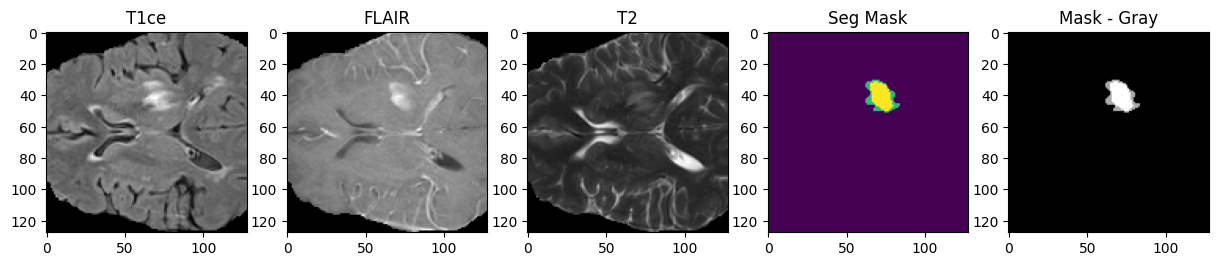

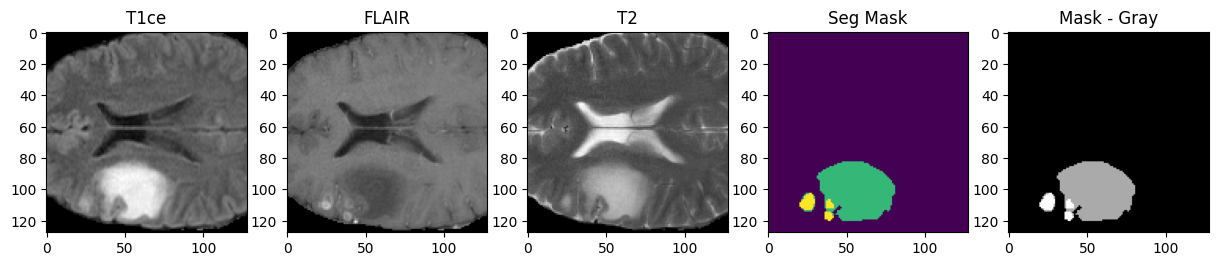

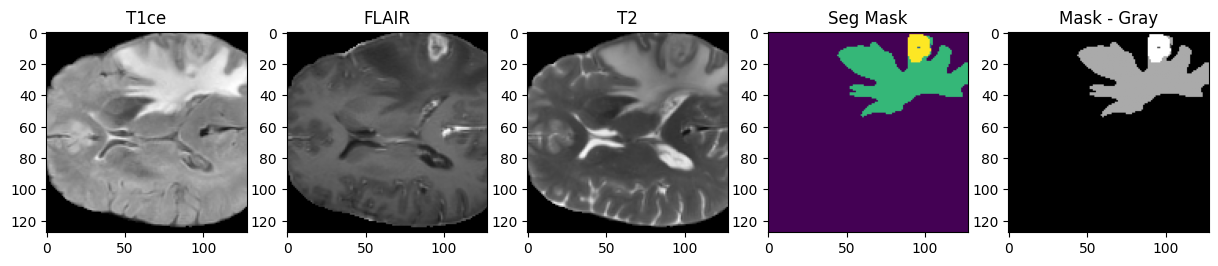

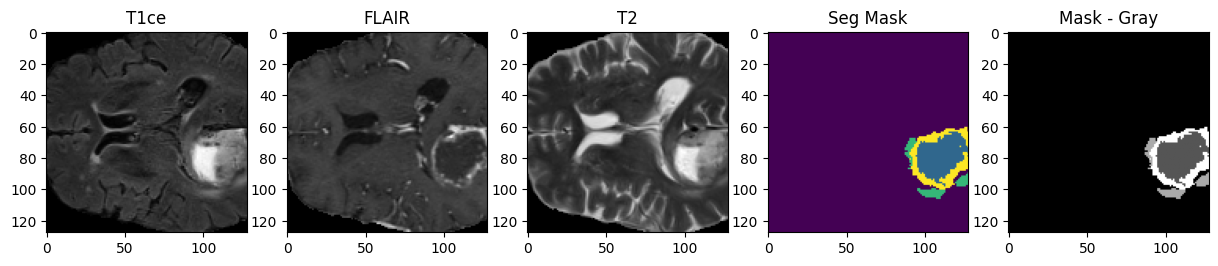

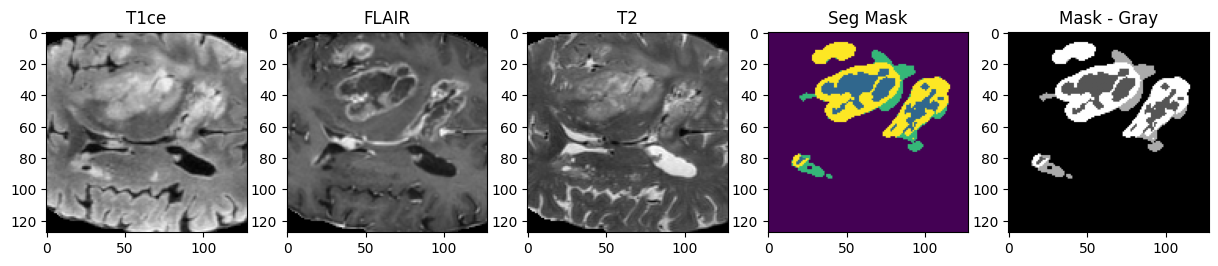

In [8]:
def visualize_slices(images, masks):
    batch_size = 5

    masks = torch.argmax(masks, dim = 1)
    
    for i in range(batch_size):
        fig, ax = plt.subplots(1,5, figsize= (15,5))
        middle_slice = images.shape[2] // 2
        ax[0].imshow(images[i, 0, middle_slice, :, :], cmap="gray")
        ax[1].imshow(images[i, 1, middle_slice, :, :], cmap="gray")
        ax[2].imshow(images[i, 2, middle_slice, :, :], cmap="gray")
        ax[3].imshow(masks[i, middle_slice, :, :], cmap="viridis")
        ax[4].imshow(masks[i, middle_slice, :, :], cmap="gray")
 
        ax[0].set_title("T1ce")
        ax[1].set_title("FLAIR")
        ax[2].set_title("T2")
        ax[3].set_title("Seg Mask")
        ax[4].set_title("Mask - Gray")
 
        plt.show()

visualize_slices(images, masks)

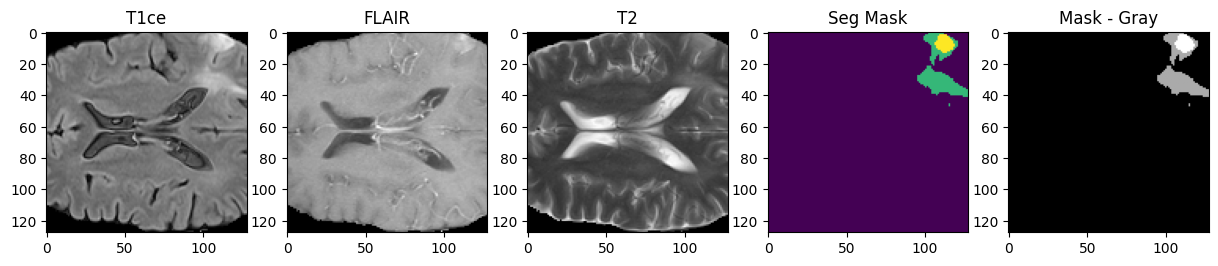

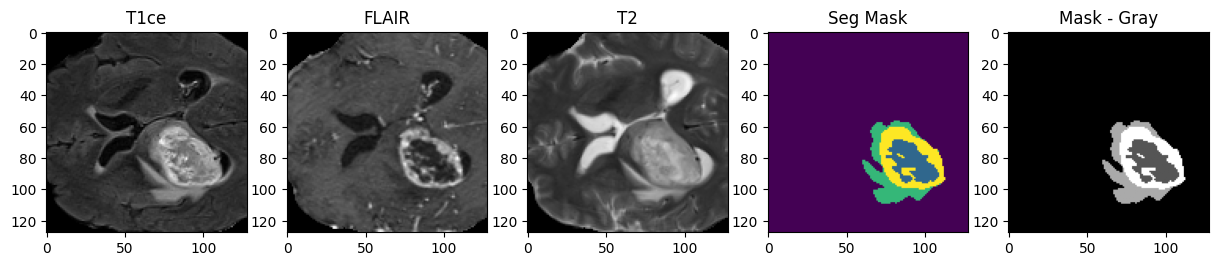

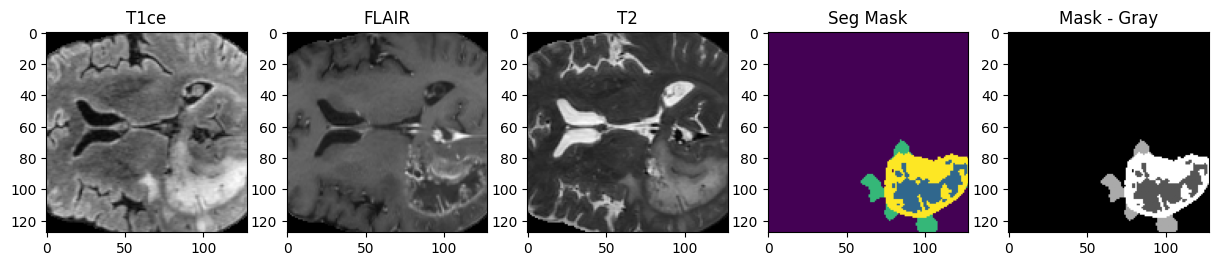

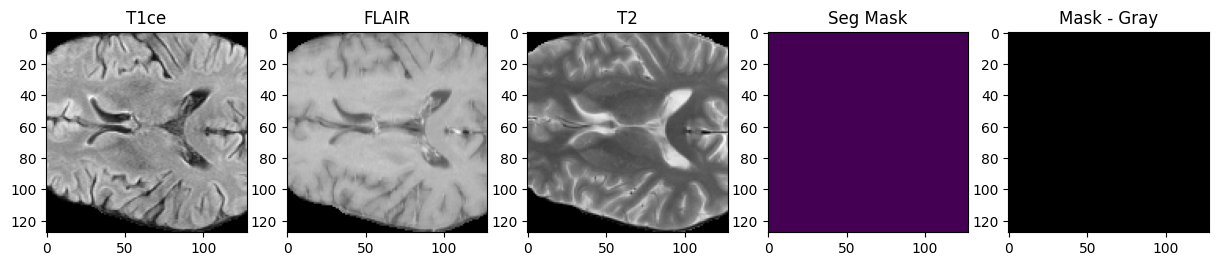

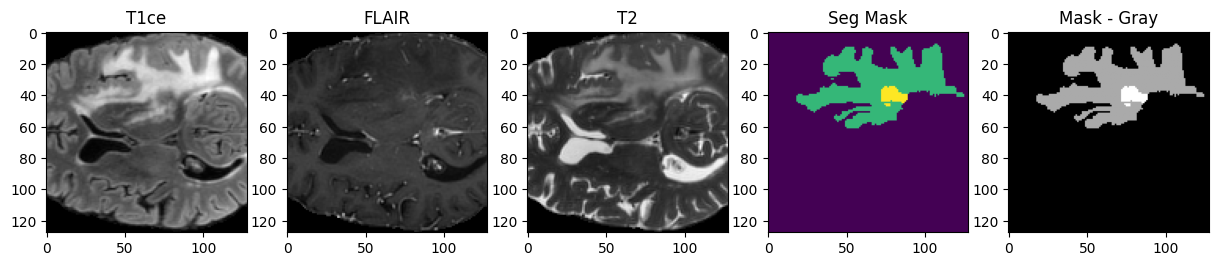

In [9]:
images, masks = next(iter(train_loader))
visualize_slices(images, masks)


Xay dung model 3D U-Net

In [10]:

def double_conv(in_channels, out_channels):
   return nn.Sequential(
       nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
       nn.BatchNorm3d(out_channels),  # Add BatchNorm3d after convolution
       nn.ReLU(inplace=True),
       nn.Dropout(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
       nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
       nn.BatchNorm3d(out_channels),  # Add BatchNorm3d after second convolution
       nn.ReLU(inplace=True)
   )

In [16]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # encoder
        self.conv1 = double_conv(in_channels=in_channels, out_channels=16)
        self.pool1 = nn.MaxPool3d(kernel_size=2)
        
        self.conv2 = double_conv(in_channels=16, out_channels=32)
        self.pool2 = nn.MaxPool3d(kernel_size=2)
        
        self.conv3 = double_conv(in_channels=32, out_channels=64)
        self.pool3 = nn.MaxPool3d(kernel_size=2)
        
        self.conv4 = double_conv(in_channels=64, out_channels=128)
        self.pool4 = nn.MaxPool3d(kernel_size=2)
        self.conv5 = double_conv(in_channels=128, out_channels=256)

        #decoder
        self.upconv6 = nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.conv6 = double_conv(in_channels=256, out_channels=128)

        self.upconv7 = nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.conv7 = double_conv(in_channels=128, out_channels=64)

        self.upconv8 = nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.conv8 = double_conv(in_channels=64, out_channels=32)

        self.upconv9 = nn.ConvTranspose3d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.conv9 = double_conv(in_channels=32, out_channels=16)

        self.out_conv = nn.Conv3d(in_channels=16, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)  # downscale
        
        c5 = self.conv5(p4)
     
        # Expansive path
        u6 = self.upconv6(c5)  # upscale
        u6 = torch.cat([u6, c4], dim=1)  # skip connections along channel dim
        c6 = self.conv6(u6)
        
        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)
        
        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)
        
        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)
        
        outputs = self.out_conv(c9)
        
        return outputs
        


In [17]:
# test model 
model = UNet3D(in_channels = 3, out_channels = 4)
print(model)

# create a example input
ip_tensor = torch.randn(1,3,128,128,128)
output = model(ip_tensor)

print(f"Input shape: {ip_tensor.shape}")
print(f"Output shape: {output.shape}")

UNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

defind loss function

In [18]:
dice_loss = smp.losses.DiceLoss(
    mode="multiclass",          # Cho phân đoạn đa lớp
    classes=None,               # Tính loss cho tất cả các lớp
    log_loss=False,             # Không dùng phiên bản log của Dice loss
    from_logits=True,           # Đầu ra của mô hình là logits thô
    smooth=1e-5,                # Hệ số làm mịn nhỏ cho sự ổn định
    ignore_index=None,          # Không bỏ qua lớp nào
    eps=1e-7                    # Epsilon cho sự ổn định số học
)

focal_loss = smp.losses.FocalLoss(
    mode="multiclass",          # Phân đoạn đa lớp
    alpha=0.25,                 # Trọng số lớp để xử lý mất cân bằng lớp
    gamma=2.0                   # Tham số tập trung cho các mẫu khó phân loại
)

def combined_loss(output, target):
    loss1 = dice_loss(output, target)
    loss2 = dice_loss(output, target)
    return (loss1 + loss2)/2

defind save checkpoint function

In [19]:
def create_checkpoint_dir(checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    try:
        num_versions = [
            int(i.split("_")[-1]) for i in os.listdir(checkpoint_dir) if "version" in i
        ]
        version_num = max(num_versions) + 1
 
    except:
        version_num = 0
 
    version_dir = os.path.join(checkpoint_dir, "version_" + str(version_num))
    os.makedirs(version_dir)
 
    print(f"Checkpoint directory: {version_dir}")
    return version_dir

In [22]:
@dataclass(frozen=True)
class TrainingConfig:
   BATCH_SIZE:      int = 4
   EPOCHS:          int = 25
   LEARNING_RATE: float = 1e-3
   NUM_CLASSES:     int = 4
   CHECKPOINT_DIR:  str = os.path.join('model_checkpoint', '3D_UNet_Brats2023')
   NUM_WORKERS:     int = 4


def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device("cuda" if gpu_available else "cpu"), gpu_available

seed_everything(SEED = 42)
DEVICE, GPU_AVAILABLE  = get_default_device()
print(DEVICE)

CKPT_DIR = create_checkpoint_dir(TrainingConfig.CHECKPOINT_DIR)
 
optimizer = AdamW(
   model.parameters(),
   lr=TrainingConfig.LEARNING_RATE, 
   weight_decay=1e-2,                # Regularization to avoid overfitting
   amsgrad=True                      # Optional AMSGrad variant
)


cuda
Checkpoint directory: model_checkpoint/3D_UNet_Brats2023/version_1


trainning one_eporch function

In [24]:
def train_one_epoch(
   model,
   loader,
   optimizer,
   num_classes,
   device="cpu",
   epoch_idx=800,
   total_epochs=10):
    
   model.train()
 
 
   loss_record = MeanMetric()
   metric_record = MeanMetric()
   acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro')  # Use macro-average accuracy
 
   loader_len = len(loader)
 
   with tqdm(total=loader_len, ncols=122) as tq:
       tq.set_description(f"Train ::  Epoch: {epoch_idx}/{total_epochs}")
 
       for data, target in loader:
           tq.update(1)
 
           data, target = data.to(device).float(), target.to(device).float()
 
           optimizer.zero_grad()
 
           output_dict = model(data)
 
           target = target.argmax(dim=1)  # Convert one-hot to class indices
 
           clsfy_out = output_dict  # classifier head output
 
           loss = combined_loss(clsfy_out, target)
 
           # Calculate gradients w.r.t training parameters
           loss.backward()
           optimizer.step()
 
           # Detach for evaluation
           with torch.no_grad():
               pred_idx = clsfy_out.argmax(dim=1)
 
               # Calculate stats and IoU
               tp, fp, fn, tn = smp.metrics.get_stats(pred_idx, target, mode='multiclass', num_classes=num_classes)
               
               # Macro IoU and class-wise IoU
               metric_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
 
               acc_record.update(pred_idx.cpu(), target.cpu())
               loss_record.update(loss.detach().cpu(), weight=data.shape[0])
               metric_record.update(metric_macro.cpu(), weight=data.shape[0])

               # del tp, fp, fn, tn  # Xóa ngay sau khi dùng
               # del pred_idx, target, loss, metric_macro
 
 
           tq.set_postfix_str(s=f"Loss: {loss_record.compute():.4f}, IoU: {metric_record.compute():.4f}, Acc: {acc_record.compute():.4f}")
 
   epoch_loss = loss_record.compute()
   epoch_metric = metric_record.compute()
   epoch_acc = acc_record.compute()
 
   return epoch_loss, epoch_metric, epoch_acc

In [25]:
# Validation function, logging macro IoU and per-class IoU.
def validate(
   model,
   loader,
   device,
   num_classes,
   epoch_idx,
   total_epochs
):
   model.eval()
 
 
   loss_record = MeanMetric()
   metric_record = MeanMetric()
   acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro')
 
   loader_len = len(loader)
 
   with tqdm(total=loader_len, ncols=122) as tq:
       tq.set_description(f"Valid :: Epoch: {epoch_idx}/{total_epochs}")
 
       for data, target in loader:
           tq.update(1)
 
           data, target = data.to(device).float(), target.to(device).float()
 
           with torch.no_grad():
               output_dict = model(data)
 
           clsfy_out = output_dict
           target = target.argmax(dim=1)  # Convert one-hot to class indices
 
           loss = combined_loss(clsfy_out, target)
           pred_idx = clsfy_out.argmax(dim=1)
 
           tp, fp, fn, tn = smp.metrics.get_stats(pred_idx, target, mode='multiclass', num_classes=num_classes)
           
           # Macro IoU
           metric_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
 
           acc_record.update(pred_idx.cpu(), target.cpu())
           loss_record.update(loss.cpu(), weight=data.shape[0])
           metric_record.update(metric_macro.cpu(), weight=data.shape[0]) #data.shape = batch
 
       valid_epoch_loss = loss_record.compute()
       valid_epoch_metric = metric_record.compute()
       valid_epoch_acc = acc_record.compute()
 
   return valid_epoch_loss, valid_epoch_metric, valid_epoch_acc

In [26]:
# Main function with logging and saving model checkpoints.
def main(*, model, optimizer, ckpt_dir, pin_memory=True, device="cpu"):
 
    total_epochs = TrainingConfig.EPOCHS
 
    # Move model to the correct device before the loop starts
    model.to(device, non_blocking=True)
 
    writer = SummaryWriter(log_dir=os.path.join(ckpt_dir, "tboard_logs"))
    best_loss = float("inf")
    live_plot = PlotLosses(outputs=[MatplotlibPlot(cell_size=(8, 3)), ExtremaPrinter()])
 
    for epoch in range(total_epochs):
        current_epoch = epoch + 1
 
        torch.cuda.empty_cache()
        gc.collect()
 
        # Train one epoch
        train_loss, train_metric, train_acc = train_one_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            num_classes=4,
            device=device,
            epoch_idx=current_epoch,
            total_epochs=total_epochs,
        )
 
        # Validate after each epoch
        valid_loss, valid_metric, valid_acc = validate(
            model=model,
            loader=val_loader,
            device=device,
            num_classes=4,
            epoch_idx=current_epoch,
            total_epochs=total_epochs,
        )
 
        # Update live plot
        live_plot.update(
            {
                "loss": train_loss,
                "val_loss": valid_loss,
                "accuracy": train_acc,
                "val_accuracy": valid_acc,
                "IoU": train_metric,
                "val_IoU": valid_metric,
            }
        )
 
        live_plot.send()
 
        # Write training and validation metrics to TensorBoard
        writer.add_scalar("Loss/train", train_loss, current_epoch)
        writer.add_scalar("Loss/valid", valid_loss, current_epoch)
        writer.add_scalar("Accuracy/train", train_acc, current_epoch)
        writer.add_scalar("Accuracy/valid", valid_acc, current_epoch)
        writer.add_scalar("IoU/train", train_metric, current_epoch)
        writer.add_scalar("IoU/valid", valid_metric, current_epoch)
 
        # Step the Cosine Annealing LR scheduler
        # scheduler.step()
 
        # Save the model if validation loss improves
        if valid_loss < best_loss:
            best_loss = valid_loss
            print("Model Improved. Saving...", end="")
 
            checkpoint_dict = {
                "opt": optimizer.state_dict(),
                "model": model.state_dict(),
            }
            torch.save(checkpoint_dict, os.path.join(ckpt_dir, "ckpt.tar"))
            del checkpoint_dict
            print("Done.\n")
 
    writer.close()
    return

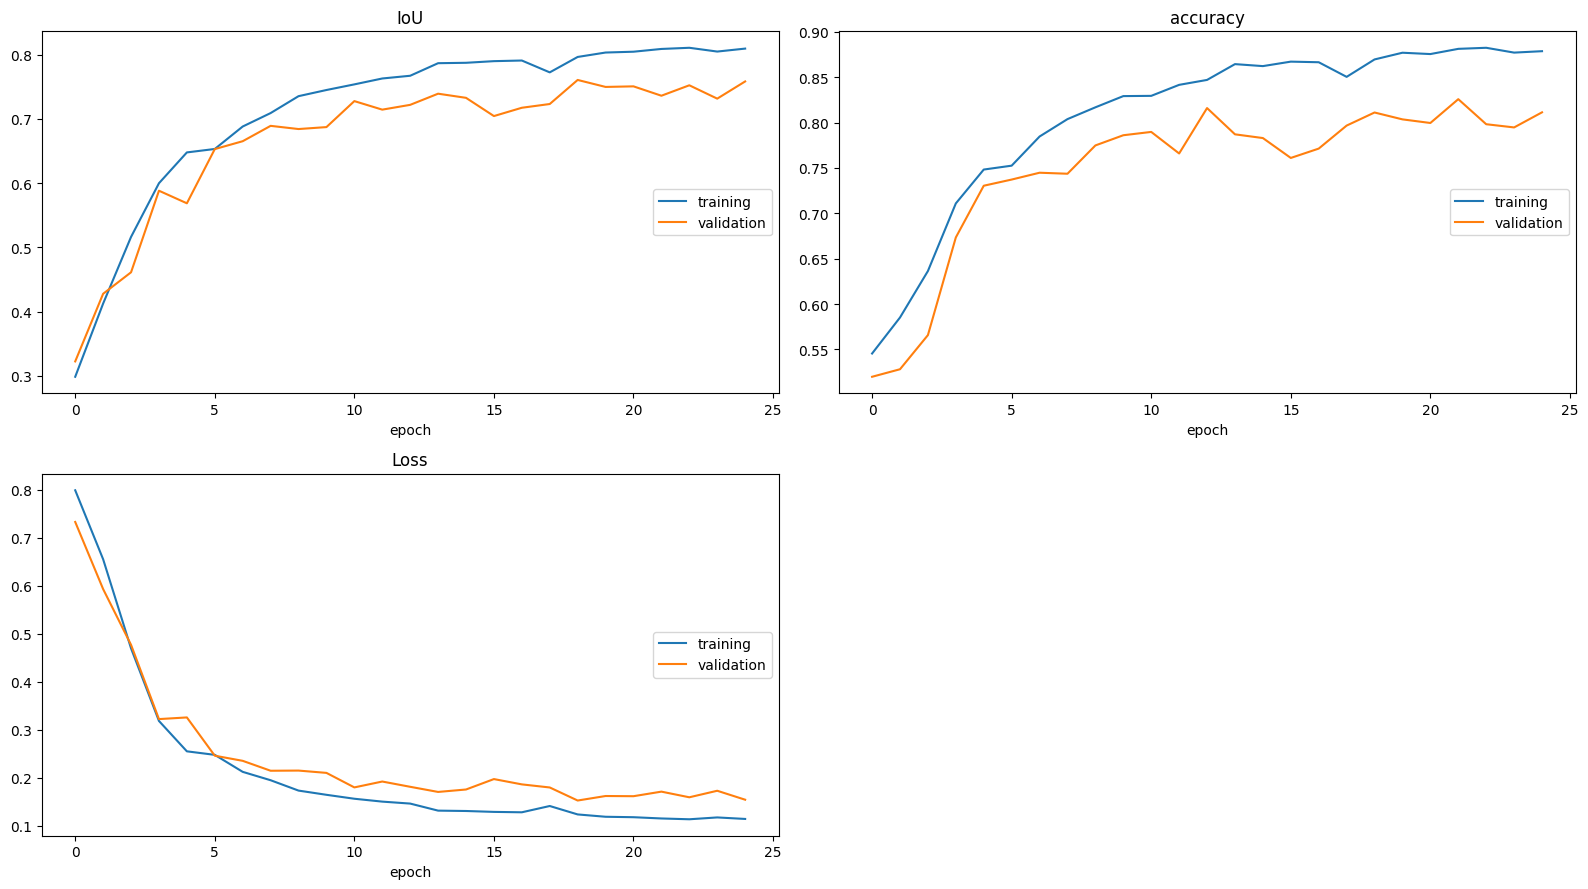

IoU
	training         	 (min:    0.299, max:    0.811, cur:    0.809)
	validation       	 (min:    0.323, max:    0.761, cur:    0.758)
accuracy
	training         	 (min:    0.545, max:    0.882, cur:    0.879)
	validation       	 (min:    0.520, max:    0.826, cur:    0.811)
Loss
	training         	 (min:    0.113, max:    0.799, cur:    0.114)
	validation       	 (min:    0.152, max:    0.733, cur:    0.154)


In [27]:
main(
   model = model,
   optimizer = optimizer,
   ckpt_dir = CKPT_DIR,
   device  = DEVICE,
   pin_memory = GPU_AVAILABLE
)